<a href="https://colab.research.google.com/github/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/blob/main/Spike_train_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


Most of the interesting things that happen in living organisms result from networks of interactions, whether among neurons in the brain, genes in a single cell, or amino acids in single protein molecule.  Especially in the context of neural networks, there is a long tradition of using ideas from statistical physics to think about the emergence of collective behavior from the microscopic interactions, with the hope that this functional collective behavior will be robust (universal?) to our ignorance of many details in these systems.  In the past decade or so, new experimental techniques have made it possible to monitor the activity of many biological networks much more completely, and the availability of these data has made the problems of analysis much more urgent: given what the new techniques can measure, can we extract a global picture of the network dynamics?  In this lecture I'll show how an old idea, the maximum entropy construction, can be used to attack this problem.  What is most exciting is that this construction provides a path directly from real data to the classical models of statistical mechanics.  I'll describe in detail how this works for a network of neurons in the retina as it responds to complex, naturalistic inputs, where the relevant model is exactly the Ising model with pairwise, frustrated interactions.   Remarkably, the data suggest that the system is poised very close to a critical point. I'll try to highlight some open theoretical questions in this field, as well as making connections to other systems.  Again, I hope we'll see the outlines of how common theoretical ideas can unify our understanding of diverse systems.  

Physicists have long explored analogies between the
statistical mechanics of Ising models and the functional
dynamics of neural networks [1, 2]. Recently it has been
suggested that this analogy can be turned into a precise
mapping [3]: In small windows of time, a single neuron i
either does ($\sigma_i = +1$) or does not ($\sigma_i = -1$) generate an
action potential or "spike" [4]; if we measure the mean
probability of spiking for each cell ($\langle \sigma_i\rangle$) and the correlations between pairs of cells ($C_{ij} = \langle \sigma_i\rangle -\langle \sigma_i\rangle \langle \sigma_j\rangle$), then
the maximum entropy model consistent with these data
is exactly the Ising model

$$ p(\boldsymbol{ \sigma} ) = \frac{1}{Z}\exp \left[  \sum_i^N H_i \sigma_i + \sum_{i< j} J_{ij} \sigma_i \sigma_j \right]$$



$$ \ell = \frac{1}{M}\sum_{m=1}^M \log p(\boldsymbol\sigma^m)$$ 

$$ \frac{\partial\ell}{\partial H_i} = \frac{1}{M}\sum_{m=1}^M  \sigma_i  - \langle \sigma_i  \rangle  =  \langle \sigma_i \rangle_\mathrm{data}  -  \langle \sigma_i\rangle_\mathrm{model} $$ 

$$ \frac{\partial\ell}{\partial J_{ij}} = \frac{1}{M}\sum_{m=1}^M  \sigma_i \sigma_j - \langle \sigma_i \sigma_j \rangle  =  \langle \sigma_i \sigma_j \rangle_\mathrm{data}  -  \langle \sigma_i \sigma_j \rangle_\mathrm{model} $$ 

In [36]:
import numpy as np
from matplotlib import pyplot as plt
plt.rc('font',**{'size':15})

import requests
import io

url = 'https://github.com/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/blob/main/neural_data.npz?raw=true'

response = requests.get(url)
response.raise_for_status()
data = np.load(io.BytesIO(response.content))
Data_sample = data['X']*2-1





In [9]:
# Define model
class Ising:
    def __init__(self, netsize):    #Create ising model
    
        self.size=netsize
        self.H=np.zeros(netsize)
        self.J=np.zeros((netsize,netsize))
        self.randomize_state()
        self.beta=1.0
    
    def randomize_state(self):
        self.s = np.random.randint(0,2,self.size)*2-1

    def SequentialMetropolisStep(self):
        for i in np.random.permutation(self.size):
            self.MetropolisStep(i)

        
    def GlauberStep(self,i=None):            #Execute step of Glauber algorithm
        if i is None:
            i = np.random.randint(self.size)
        h = self.H[i] + np.dot(self.J[i,:]+self.J[:,i],self.s)
        self.s[i] = int(np.random.rand()*2-1 < np.tanh(self.beta*h))*2-1   # Glauber

    def SequentialGlauberStep(self):
        for i in np.random.permutation(self.size):
            self.GlauberStep(i)

### Generating reference data distribution

We generate a sample of spiking neuron data using a network with a random configuration. We store the relevant statistics in `m_data ` and  `Cov_data `.


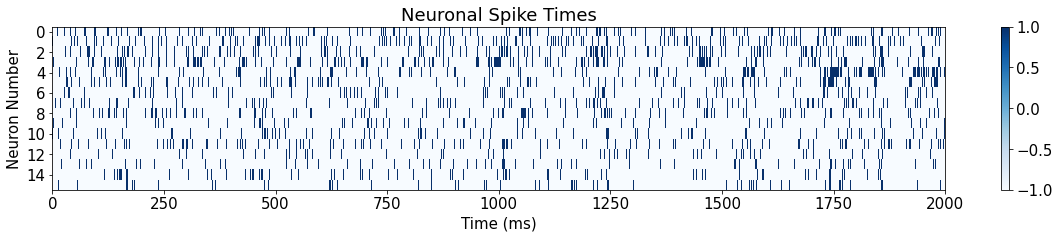

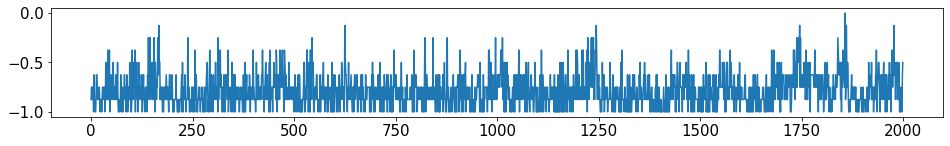

In [41]:
N=Data_sample.shape[0]
iu1=np.triu_indices(N,1)

Data_sample_segment = Data_sample[:,5000:5000+T]

T=2000

I_data = Ising(N)
I_data.H = -0.1 + 0.05*np.random.randn(N)
I_data.J[iu1] = 1/N + np.random.randn(N*(N-1)//2)/np.sqrt(N)

### Alternatively, we could generate data from another Ising model
#Data_sample = np.zeros((N,T))
#I_data.randomize_state()
#for t in range(T//5):
#  I_data.SequentialGlauberStep()
#for t in range(T):
#  I_data.SequentialGlauberStep()
#  Data_sample[:,t] = I_data.s


fig, ax = plt.subplots(figsize=(20,3))

plt.imshow(Data_sample_segment, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()

ax.set_xlim([0, T])
ax.set_xlabel('Time (ms)')
# specify tick marks and label label y axis
ax.set_yticks(range(0,N,2))
ax.set_ylabel('Neuron Number')
ax.set_title('Neuronal Spike Times') 


fig, ax = plt.subplots(figsize=(16,2))
plt.plot(np.mean(Data_sample_segment,axis=0))


m_data = np.mean(Data_sample,axis=1)
Cov_data = np.cov(Data_sample)

## Learning our model

Given the statistics from the data generated by the reference model, we will implement our learning rule to infer the parameters of a new model.

A simple way to display the progress of learning is measuring the mean squared error between the covariances of the original and inferred models.

Text(0.5, 0, 'epoch')

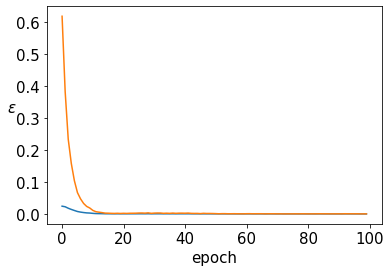

In [38]:
I = Ising(N)
I.H = np.zeros(N)
I.J = np.zeros((N,N))

R=100
eta=0.2

error_m = np.zeros(R)
error_C = np.zeros(R)

for rep in range(R):
  Model_sample = np.zeros((N,T))
  I.randomize_state()
  for t in range(T//5):
    I.SequentialGlauberStep()
  for t in range(T):
    I.SequentialGlauberStep()
    Model_sample[:,t] = I.s
  m = np.mean(Model_sample,axis=1)
  Cov  = np.cov(Model_sample)

  I.H += eta*(m_data-m)
  I.J[iu1] += eta*(Cov_data-Cov)[iu1]

  error_C[rep] = np.mean((Cov_data-Cov)**2)
  error_m[rep] = np.mean((m_data-m)**2)

plt.figure()
plt.plot(error_C)
plt.plot(error_m)
plt.ylabel(r'$\epsilon$',rotation=0)
plt.xlabel(r'epoch')


### Comparison of the original and inferred model

Here we show data, statistics and parameters of the original and inferred models. First, we can show the original time series and an example of a time series generated by the model

[-0.683 -0.66  -0.732 -0.71  -0.718 -0.73  -0.782 -0.764 -0.804 -0.845
 -0.836 -0.834 -0.854 -0.871 -0.875 -0.891]
[-0.65518475 -0.68326449 -0.70916448 -0.70964515 -0.71688865 -0.72479167
 -0.76318893 -0.76328953 -0.78993846 -0.81049525 -0.82679313 -0.8369318
 -0.85121759 -0.85603541 -0.86742604 -0.87004175]


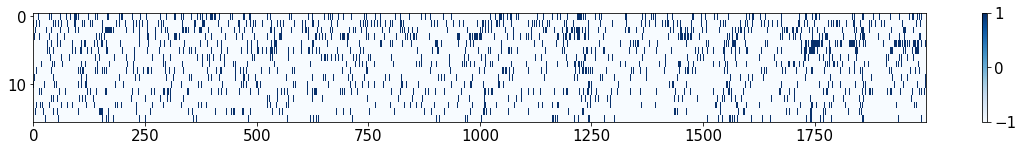

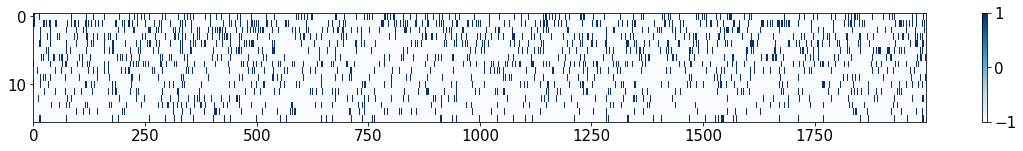

In [42]:
print(m)
print(m_data)
plt.figure(figsize=(20,2))
plt.imshow(Data_sample_segment, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()

plt.figure(figsize=(20,2))
plt.imshow(Model_sample, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()

#### Compare covariance matrices

To test the sucess of the learning rule, we can compare the original and learned covariance matrices

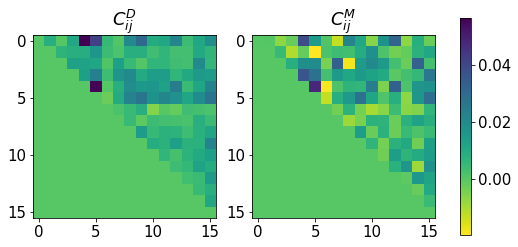

In [43]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(np.triu(Cov_data,1),cmap='viridis_r',vmin=min(np.min(np.triu(Cov_data,1)),np.min(np.triu(Cov,1))), vmax=max(np.max(np.triu(Cov_data,1)),np.max(np.triu(Cov,1))))
ax[0].set_title(r'$C_{ij}^D$')
im = ax[1].imshow(np.triu(Cov,1), cmap='viridis_r',vmin=min(np.min(np.triu(Cov_data,1)),np.min(np.triu(Cov,1))), vmax=max(np.max(np.triu(Cov_data,1)),np.max(np.triu(Cov,1))))
ax[1].set_title(r'$C_{ij}^M$')
fig.colorbar(im, ax=ax.ravel().tolist());


#### Compare coupling matrices

If we learn data from a given Ising model, to quantify the success of inference, we can compare the original and learned parameters, e.g. the coupling matrix

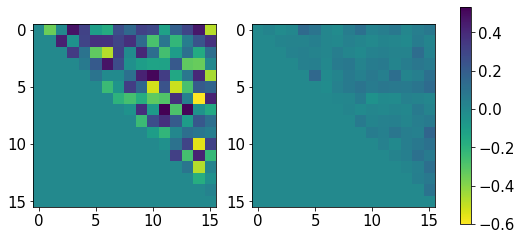

In [44]:

#fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
#im = ax[0].imshow(np.triu(I_data.J,1),cmap='viridis_r',vmin=min(np.min(np.triu(I_data.J,1)),np.min(np.triu(I.J,1))), vmax=max(np.max(np.triu(I_data.J,1)),np.max(np.triu(I.J,1))))
#im = ax[1].imshow(np.triu(I.J,1), cmap='viridis_r',vmin=min(np.min(np.triu(I_data.J,1)),np.min(np.triu(I.J,1))), vmax=max(np.max(np.triu(I_data.J,1)),np.max(np.triu(I.J,1))))
#fig.colorbar(im, ax=ax.ravel().tolist())